# Predicting hospital length-of-stay at time of admission

## Table of Contents
* [1. __Project Overview__](#heading--1)
  * [1.1. Problem Statement](#heading--1-1)
  * [1.2. Metrics](#heading--1-2)
  * [1.3. Load libraries](#heading--1-3)
  * [1.4. Load the data ](#heading--1-4)
* [2. __Data Exploration and Feature Engineering__](#heading--2) 
  * [2.1. Length-of-Stay (Feature Engineering)](#heading--2-1)
  * [2.2. died](#heading--2-2)
  * [2.3. unitcode (Feature Engineering)](#heading--2-3)
  * [2.4. cward (Feature Engineering)](#heading--2-4)
  * [2.5. Admission class of patient(cadmitclass)](#heading--2-5)
  * [2.6. ecomplaint and ecomplaintcode](#heading--2-6)
  * [2.7. postcode (Feature Engineering)](#heading--2-7)
  * [2.8. Admission Type (Feature Engineering)](#heading--2-8)
  * [2.9. Insurance](#heading--2-9)
  * [2.10. ICD-10-AM Code (Feature Engineering)](#heading--2-10)
  * [2.11. Age (Feature Engineering)](#heading--2-11)
* [3. __Data Preprocessing__](#heading--3) 
  * [3.1. Drop columns](#heading--3-1)
  * [3.2. Missing values](#heading--3-2)
  * [3.3. Recategorization](#heading--3-3)
* [4. __Save the data__](#heading--4) 
  
  
  
  
  
  
  
  
  



<div id="heading--1"/>

## 1.Project Overview
Hospital length-of-stay (LOS). LOS is defined as the time between hospital admission and discharge measured in days.
The hospitals like to identify patients of high LOS risk at the time of admission. Once identified, patients with high LOS risk can have their __treatment plan optimized to minimize LOS__ and lower the chance of __getting a hospital-acquired condition__ such as staph infection. Another benefit is that prior knowledge of LOS can aid in logistics such as __room and bed allocation planning.__


<div id="heading--1-1"/>

### 1.1. Problem Statement

* __The goal of this project is to create a model that predicts the length-of-stay for each patient at time of admission.__
* The health data associated with ~141,559 unique hospital admision during 2016/9 - 2019/10.

<div id="heading--1-2"/>

### 1.2. Metrics


The expected outcome of this project is to develop a model that will be better at predicting __hospital LOS__ than the industry standards of median and average LOS. The __median LOS__ is simply the median LOS of past admissions to a hospital. Similarly, a second commonly used metric in healthcare is the average, or mean LOS. To measure performance, I’ll compare the prediction model against the median and average LOS using __the root-mean-square error (RMSE).__ 
<center><img src="LOS/RMSE.png"/></center>

* The ultimate goal is to develop a prediction model that results in a lower RMSE than the average or median models. 

There is a multitude of regression models available for predicting LOS. To determine the best regression model for this work (of the subset of models that will be evaluated), the R2 (R-squared) score will be used. The R2 is a __measure of the goodness of the fit of a model__. In other words, it is the proportion of the variance in the dependent variable that is predictable from the independent variables. R2 is defined as the following equation where ($y_i$) is an observed data point, ($\hat{y}$) is the mean of the observed data, and ($f_i$) the predicted model value.
<center><img src="LOS/r2.png"/></center>

* Best possible R2 score is 1.0 and a negative value means it is worse than a constant model, average or median in this case.

<div id="heading--1-3"/>

### 1.3. Load libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import sys
import glob
import os
from data_prepare                  import data_prep
from time                          import sleep
import geopandas                   as gpd
import numpy                       as np
import matplotlib.pyplot           as plt
import seaborn                     as sns
import pandas                      as pd
import missingno                   as msno
import statsmodels.api             as sm
from tqdm.notebook                 import tqdm
from utils                         import *
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats                   import loguniform
from cf_matrix                     import make_confusion_matrix
from collections                   import Counter
from xgboost                       import XGBClassifier


from sklearn.model_selection       import train_test_split
from sklearn.preprocessing         import StandardScaler
from sklearn.preprocessing         import MinMaxScaler
from sklearn.preprocessing         import PowerTransformer
from sklearn.model_selection       import cross_validate
from sklearn.model_selection       import KFold
from sklearn.model_selection       import RepeatedStratifiedKFold
from sklearn.model_selection       import cross_val_score
from sklearn.model_selection       import GridSearchCV
from sklearn.model_selection       import RandomizedSearchCV
from sklearn.metrics               import classification_report
from sklearn.metrics               import confusion_matrix
from sklearn.metrics               import accuracy_score
from sklearn.metrics               import recall_score
from sklearn.metrics               import fbeta_score
from imblearn.metrics              import sensitivity_score
from sklearn.metrics               import make_scorer
from sklearn.linear_model          import LogisticRegression 
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes           import GaussianNB
from sklearn.svm                   import SVC
from sklearn.feature_selection     import SelectKBest
from sklearn.feature_selection     import chi2
from sklearn.feature_selection     import RFE
from sklearn.ensemble              import RandomForestClassifier
from sklearn.ensemble              import ExtraTreesClassifier
from sklearn.ensemble              import GradientBoostingClassifier
from sklearn.ensemble              import BaggingClassifier
import gc

pd.reset_option('all')
%matplotlib inline

data_path = 'data_2021-may-15/'


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



<div id="heading--1-4"/>

### 1.4. Load the data

In [2]:
df =  pd.read_csv(data_path+'@admission_all.csv', low_memory=False)
print('Dimensions of the dataset:\n',df.shape)

Dimensions of the dataset:
 (141559, 145)


In [3]:
df[['visit','urno']].nunique()

visit    141558
urno      71794
dtype: int64

<div id="heading--2"/>

## 2. Data Exploration and Feature Engineering

I is needed to figure out a strategy to extract the target Length-of-Stay (LOS) values and understand what features (independent variables) may be useful in predicting LOS.

<div id="heading--2-1"/>

### 2.1. Length-of-Stay (Feature Engineering)

In [4]:
# Step 2: Length-of-Stay (Feature Engineering)
# Convert admission and discharge times to datatime type
df['admitdt'] = pd.to_datetime(df['admitdt'])
df['dischargedt'] = pd.to_datetime(df['dischargedt'])

In [5]:
# Convert timedelta type into float 'days', 86400 seconds in a day
df['LOS'] = (df['dischargedt'] - df['admitdt']).dt.total_seconds()/86400

In [59]:
# Verify
#df[['admitdt', 'dischargedt', 'LOS']].head()
df[['admitdt', 'dischargedt', 'LOS']].sample(n=20)

,admitdt,dischargedt,LOS
581162,2018-05-18 21:42:01,2018-05-20 10:00:00,1.512488
594515,2018-06-08 17:15:00,2018-06-13 12:30:00,4.802083
335684,2019-01-15 10:28:15,2019-01-15 16:29:00,0.250521
140715,2017-10-19 10:10:00,2017-10-19 11:20:00,0.048611
37892,2018-08-13 03:44:02,2018-08-18 09:38:04,5.245856
324637,2017-09-21 23:49:17,2017-09-22 09:24:00,0.399109
403894,2017-05-31 22:35:00,2017-06-03 13:08:41,2.606725
126363,2017-04-26 06:33:03,2017-05-02 14:11:04,6.318067
106284,2017-01-25 06:57:59,2017-01-25 11:27:45,0.187338
146897,2017-11-21 14:10:24,2017-11-21 17:24:19,0.134664


* __Statistical description OF LOS__

In [7]:
df['LOS'].describe()

count    141559.000000
mean          2.586629
std           5.995027
min           0.001146
25%           0.165116
50%           0.346736
75%           2.555556
max         300.887465
Name: LOS, dtype: float64

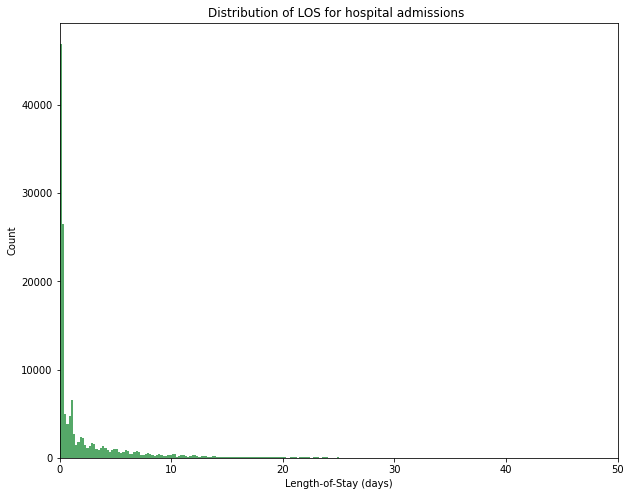

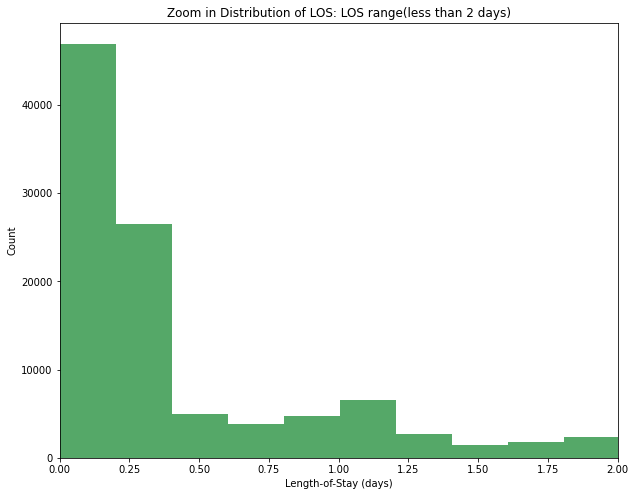

In [8]:
plot_hist(df,'LOS', 1500, '#55a868', 'Distribution of LOS for hospital admissions ', 'Count', 'Length-of-Stay (days)', (0, 50))
plot_hist(df,'LOS', 1500, '#55a868', 'Zoom in Distribution of LOS: LOS range(less than 2 days)', 'Count', 'Length-of-Stay (days)',(0, 2))

<div id="heading--2-2"/>

### 2.2. died

Patients who __died at the hospital__ will later be __dropped__ from the DataFrame 
as they would bias the LOS since they never were discharged 'alive' 
from the hospital. In other words, LOS would be shorter for this group.

In [9]:
# Mark admissions where patients died in boolean column
df['died'] = df['died'].map(dict(Yes=1, No=0))

In [10]:
print("{} of {} patients died in the hospital".format(df['died'].sum(), df['urno'].nunique()))

1022 of 71794 patients died in the hospital


In [11]:
# drop atients who died
df = df[df.died != 1]

In [12]:
# Hospital LOS metrics for later comparison
actual_mean_los = df['LOS'].mean().round(2)
actual_median_los = df['LOS'].median().round(2) 

print('Mean  LOS: {}'.format(actual_mean_los))
print('Mdian LOS: {}'.format(actual_median_los))

Mean  LOS: 2.54
Mdian LOS: 0.34


<div id="heading--2-3"/>

### 2.3. unitcode

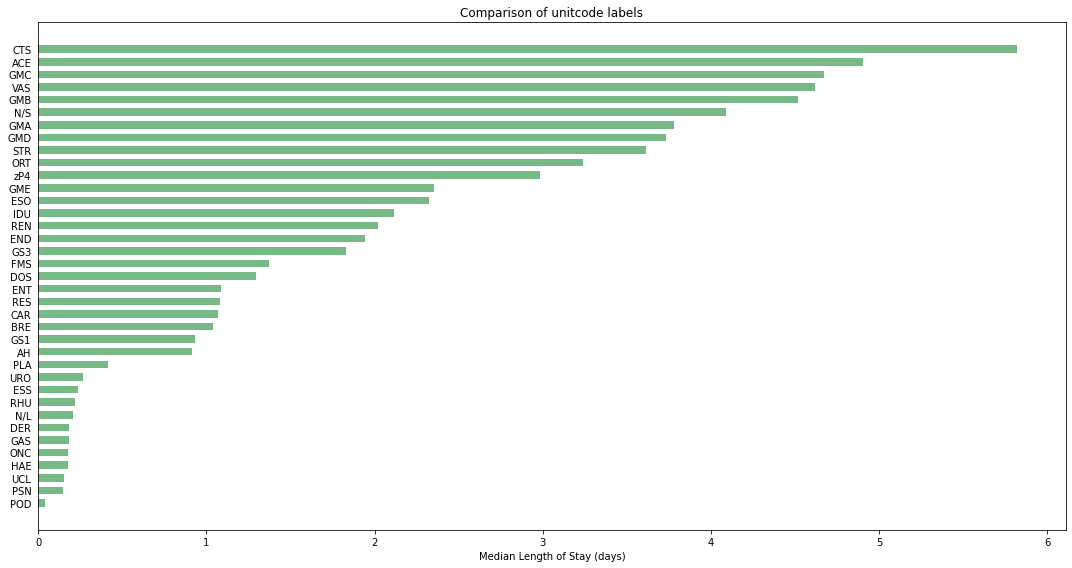

In [13]:
# Look at median LOS for groups
plot_los_groupby(df,'unitcode', size=(15,8))

In [14]:
check_list = ['unitcode']
value_counts_percent(df,check_list)

,+,%
unitcode,,
ESS,32709,23.27%
GAS,15812,11.25%
HAE,11513,8.19%
CAR,8377,5.96%
N/L,7749,5.51%
ONC,6830,4.86%
ORT,6730,4.79%
URO,5157,3.67%
PLA,5086,3.62%


* following columns are the same:
    * vascular = unitcode_VAS
    * stroke = unitcode_STR
    * respiratory = unitcode_RES
    * renal = unitcode_REN
    * nsurg = unitcode_N/S
    * genmed = unitcode_GMC and unitcode_GMD
    * cts = unitcode_CTS
    * gensurg = unitcode_GS1 and unitcode_GS3
    * ort = unitcode_ORT
    * ent = unitcode_ENT
    * card = unitcode_CAR
    
So we will __drop__ them

<div id="heading--2-4"/>

### 2.4. cward

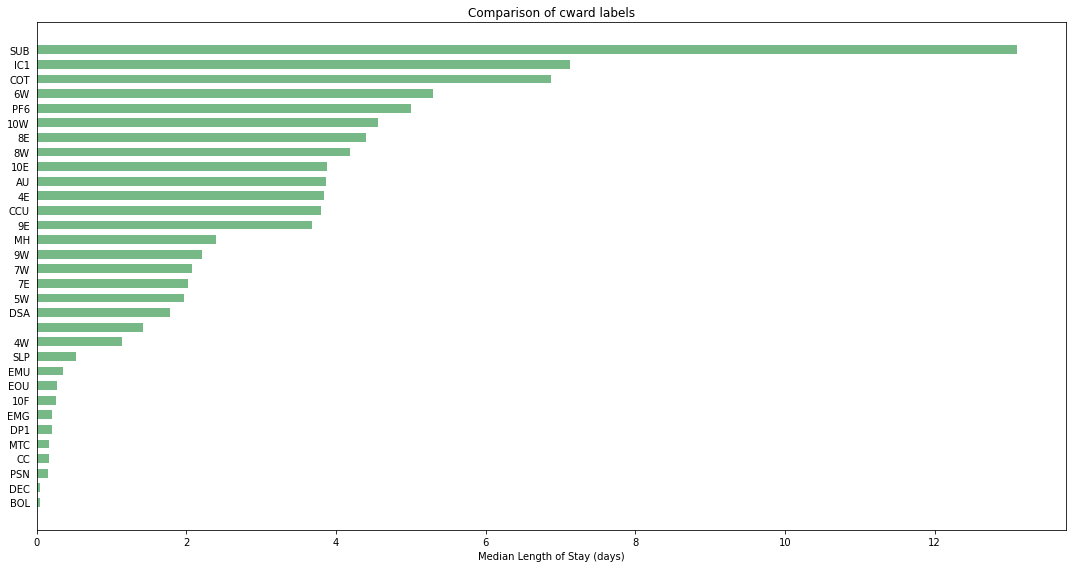

In [15]:
# Look at median LOS for groups
plot_los_groupby(df,'cward', size=(15,8))

In [16]:
check_list = ['cward']
value_counts_percent(df,check_list)

,+,%
cward,,
DP1,23669,16.84%
EMU,21225,15.10%
EOU,16432,11.69%
CC,15654,11.14%
MTC,13042,9.28%
9E,5846,4.16%
7E,5183,3.69%
7W,5082,3.62%
5W,4786,3.41%


<div id="heading--2-5"/>

### 2.5. Admission class of patient(cadmitclass) + csource


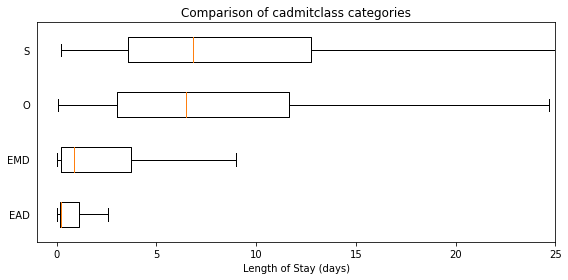

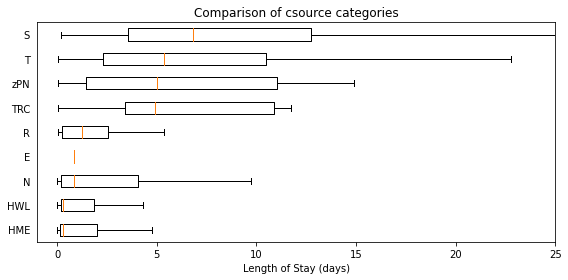

In [17]:
# Look at median LOS for groups
boxplot_los_groupby(df,'cadmitclass', los_range=(-1, 25))
boxplot_los_groupby(df,'csource', los_range=(-1, 25))


* following columns are the same:
    * (nhin    <-->  csource_N) ==> remove:    'nhin'
    * (statin  <-->  csource_S <--> cadmitclass_S) ==> remove:    'csource_S' & 'cadmitclass_S'  
    * (transin <-->  csource_T) ==> remove:    'transin'

    
So we will __drop__ them


<div id="heading--2-6"/>

### 2.6. ecomplaint and ecomplaintcode

In [18]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    check_list = ['ecomplaint', 'ecomplaintcode']
    value_counts_percent(df,check_list, comp=True, condition=None)
    
    

,,+,%
ecomplaint,ecomplaintcode,,
PAIN - ABDOMEN,PAI,6361,10.73%
PAIN - CHEST,PCH,6203,10.46%
SHORT OF BREATH,SOB,4006,6.76%
FEBRILE ILLNESS,FEB,2616,4.41%
PAIN - BACK,PBK,1715,2.89%
PAIN - LIMB,PLI,1526,2.57%
HEADACHE,HED,1515,2.55%
OTHER,OTH,1457,2.46%
DIZZY,DIZ,1306,2.20%


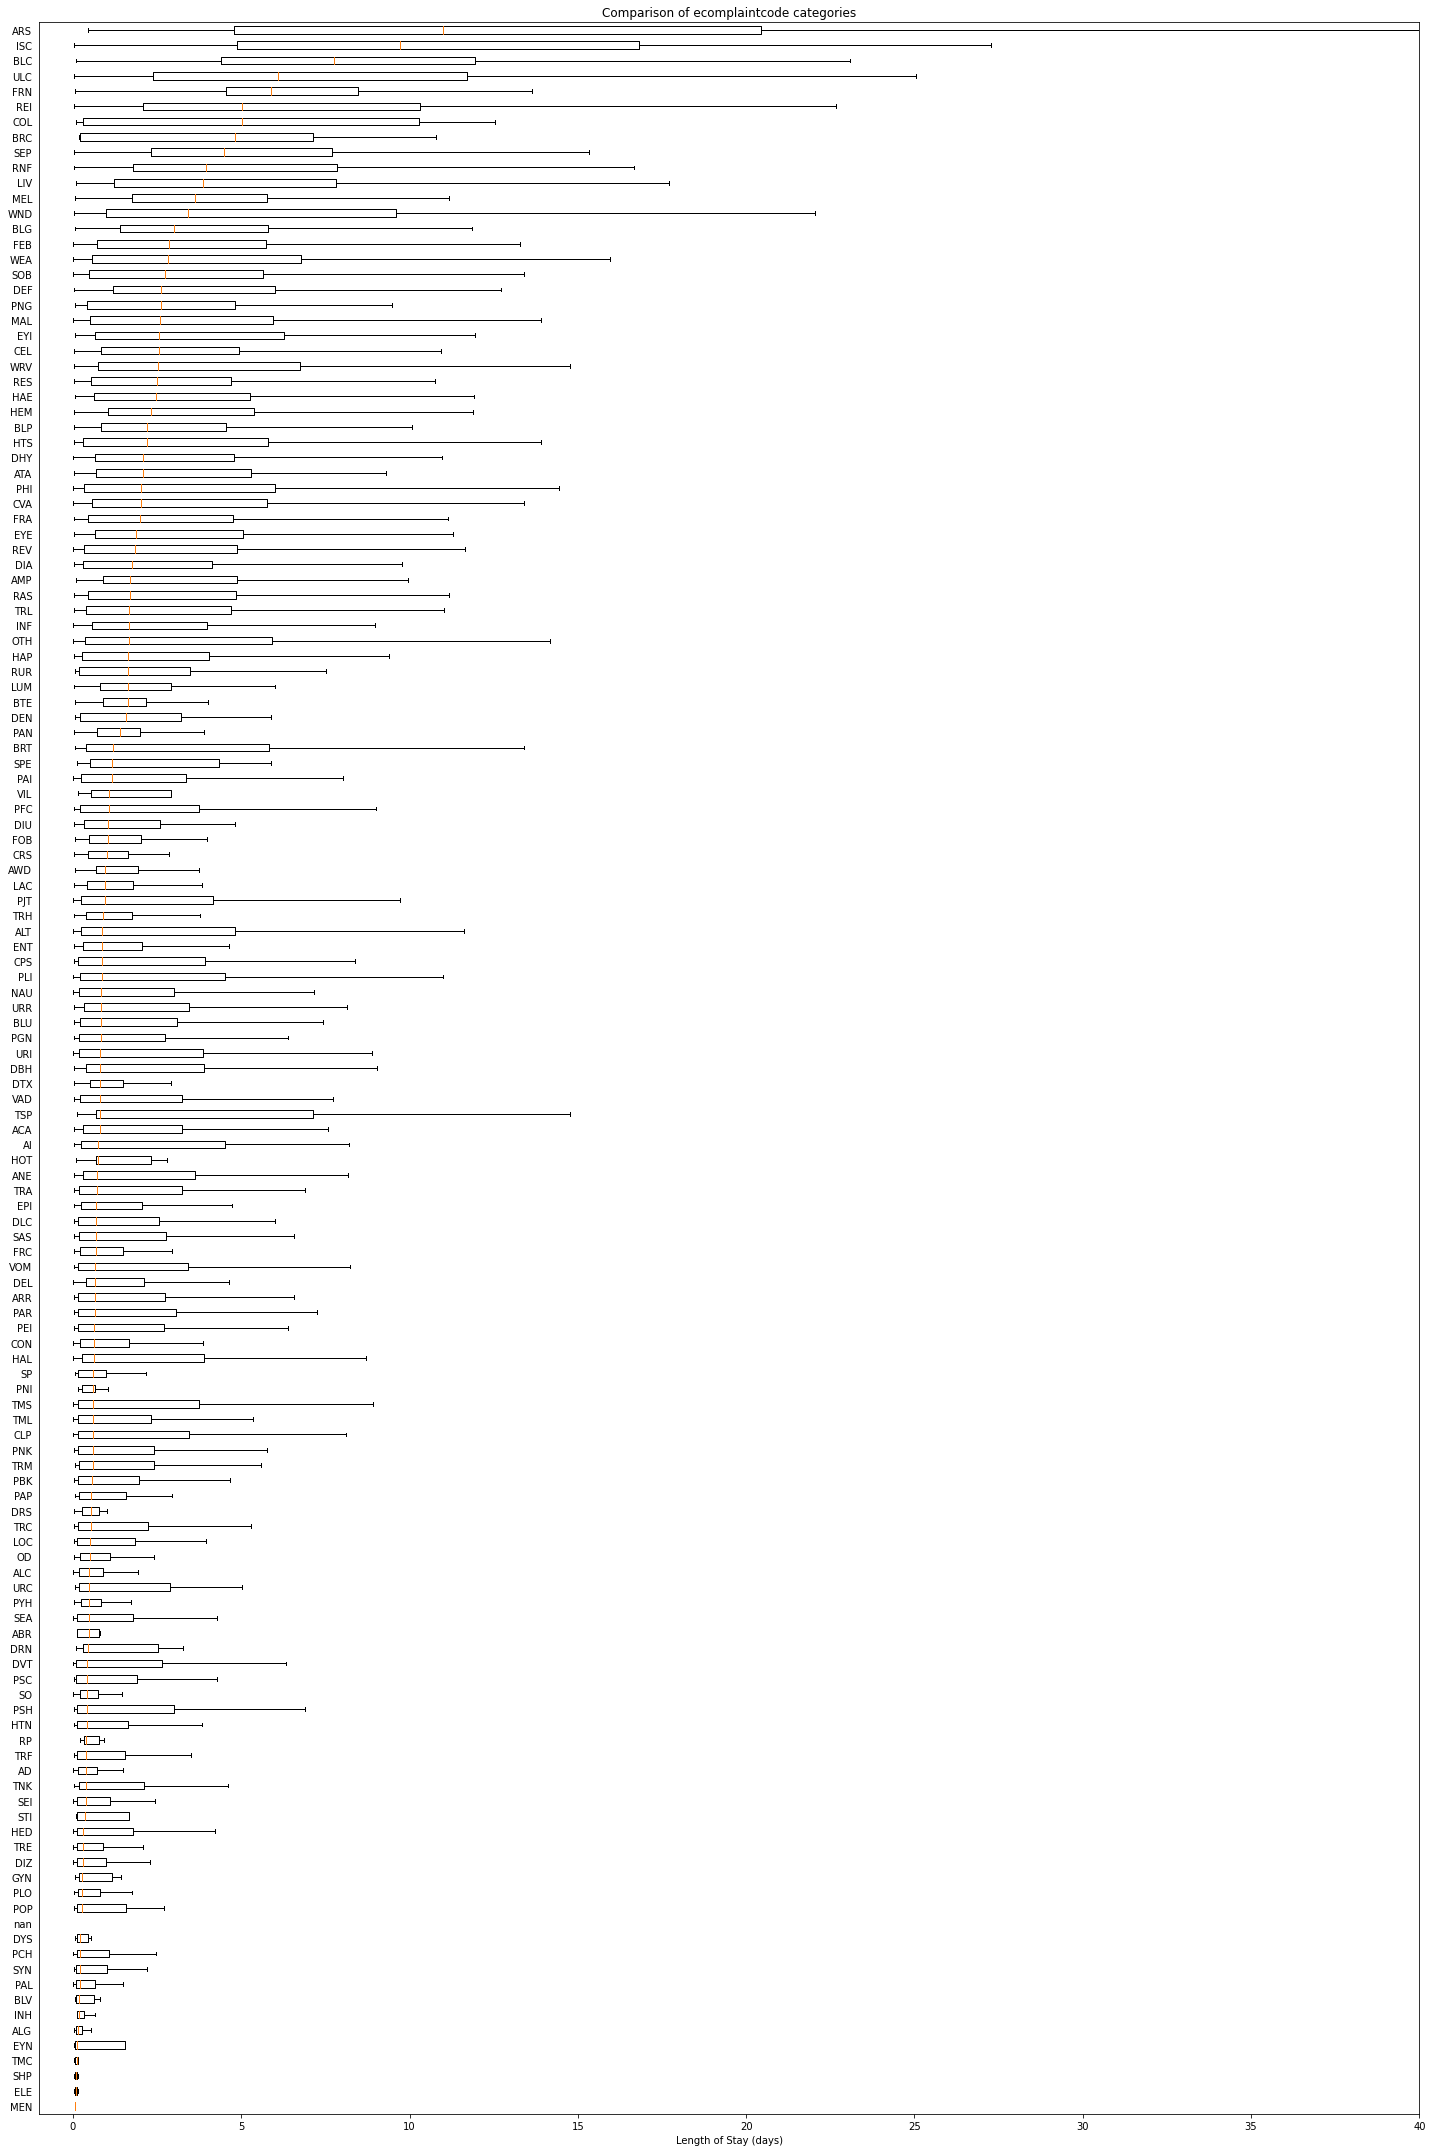

In [19]:
boxplot_los_groupby(df,'ecomplaintcode', los_range=(-1, 40), size=(20,30))


<div id="heading--2-7"/>

### 2.7. postcode (Feature Engineering)

In [20]:
#df.postcode
print('sum of missing value in post code: {}'.format(df.postcode.isna().sum()))
df['postcode'] = df['postcode'].fillna(0)


sum of missing value in post code: 2949


In [21]:
df['postcode'] = df['postcode'].astype('int')

* __Load Australian Post code .csv__

In [22]:
postcode_csv='LOS/extra_info/australian_postcodes.csv'
df_pc = pd.read_csv(postcode_csv)

In [23]:
df_pc[['postcode','state', 'sa4','sa4name','Lat_precise','Long_precise']].head()

,postcode,state,sa4,sa4name,Lat_precise,Long_precise
0,200,ACT,NaN,NaN,-35.277700,149.119000
1,200,ACT,NaN,NaN,-35.277700,149.118527
2,800,NT,701.0,Darwin,-12.393279,130.776661
3,801,NT,701.0,Darwin,-12.463440,130.845642
4,804,NT,701.0,Darwin,-12.432480,130.846254


* __Merge postcode data with hospital data__

In [24]:
df = df.merge(df_pc[['postcode','state', 'sa4','sa4name','Lat_precise','Long_precise']], on="postcode", how='left')
del df_pc
gc.collect()

77701

In [25]:
Loc = df[['state','sa4name', 'Long_precise','Lat_precise']].rename(columns={'Lat_precise': 'latitude','Long_precise':'longitude'})
Loc = Loc[Loc.longitude > 100]
VIC_df = Loc.query("state == 'VIC' and longitude > 140 and longitude < 150")


In [26]:

world = gpd.read_file( gpd.datasets.get_path('naturalearth_lowres') )
Australia_ = world.query('name == "Australia"')

Australia = gpd.read_file('LOS/extra_info/1270055003_lga_2020_aust_shp/LGA_2020_AUST.shp') #load the data using Geopandas
VIC_state = Australia[Australia['STE_NAME16']=='Victoria'] #Select the data for the state


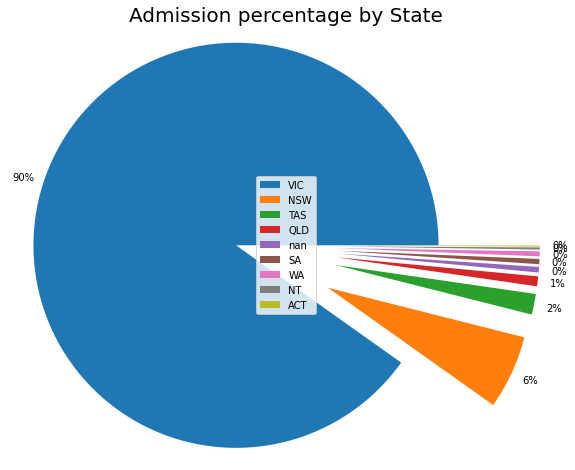

In [27]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    plt_cnf={'explode':[0,0.5], 'startangle':0,'labeldistance':1.9, 'labels':False, 'title':'Admission percentage by State'}
    value_counts_percent(df,['state'], plot=True, plt_cnf=plt_cnf)

<Figure size 720x576 with 0 Axes>

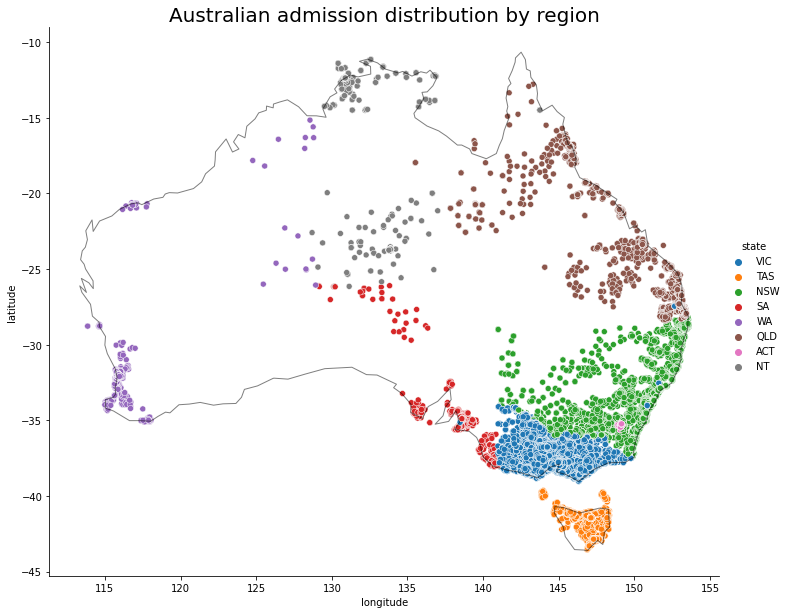

In [28]:
plt.figure()
rel = sns.relplot( x="longitude", y="latitude", hue="state", data=Loc, height=10,);
Australia_.plot(facecolor="none",edgecolor="black", ax=rel.fig.axes[0], alpha=0.5)# parse dates for plot's title
plt.title('Australian admission distribution by region', fontdict = {'fontsize' : 20})
plt.show()

* __postcode = 3065__ is located in   --->   __Melbourne - Inner__

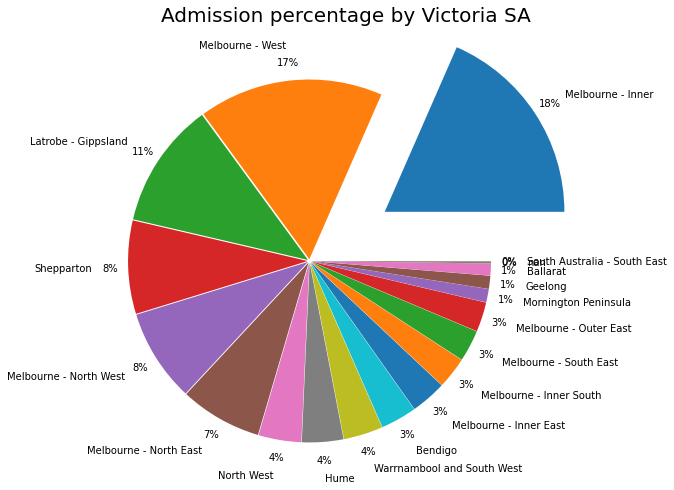

In [29]:

with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    plt_cnf={'explode':[0.5,0.01], 'startangle':0,'labeldistance':1.2, 'labels':True, 'title':'Admission percentage by Victoria SA'}
    value_counts_percent(df,'sa4name', comp=False, condition=df.state=='VIC', plot=True, plt_cnf=plt_cnf)
    

<Figure size 720x576 with 0 Axes>

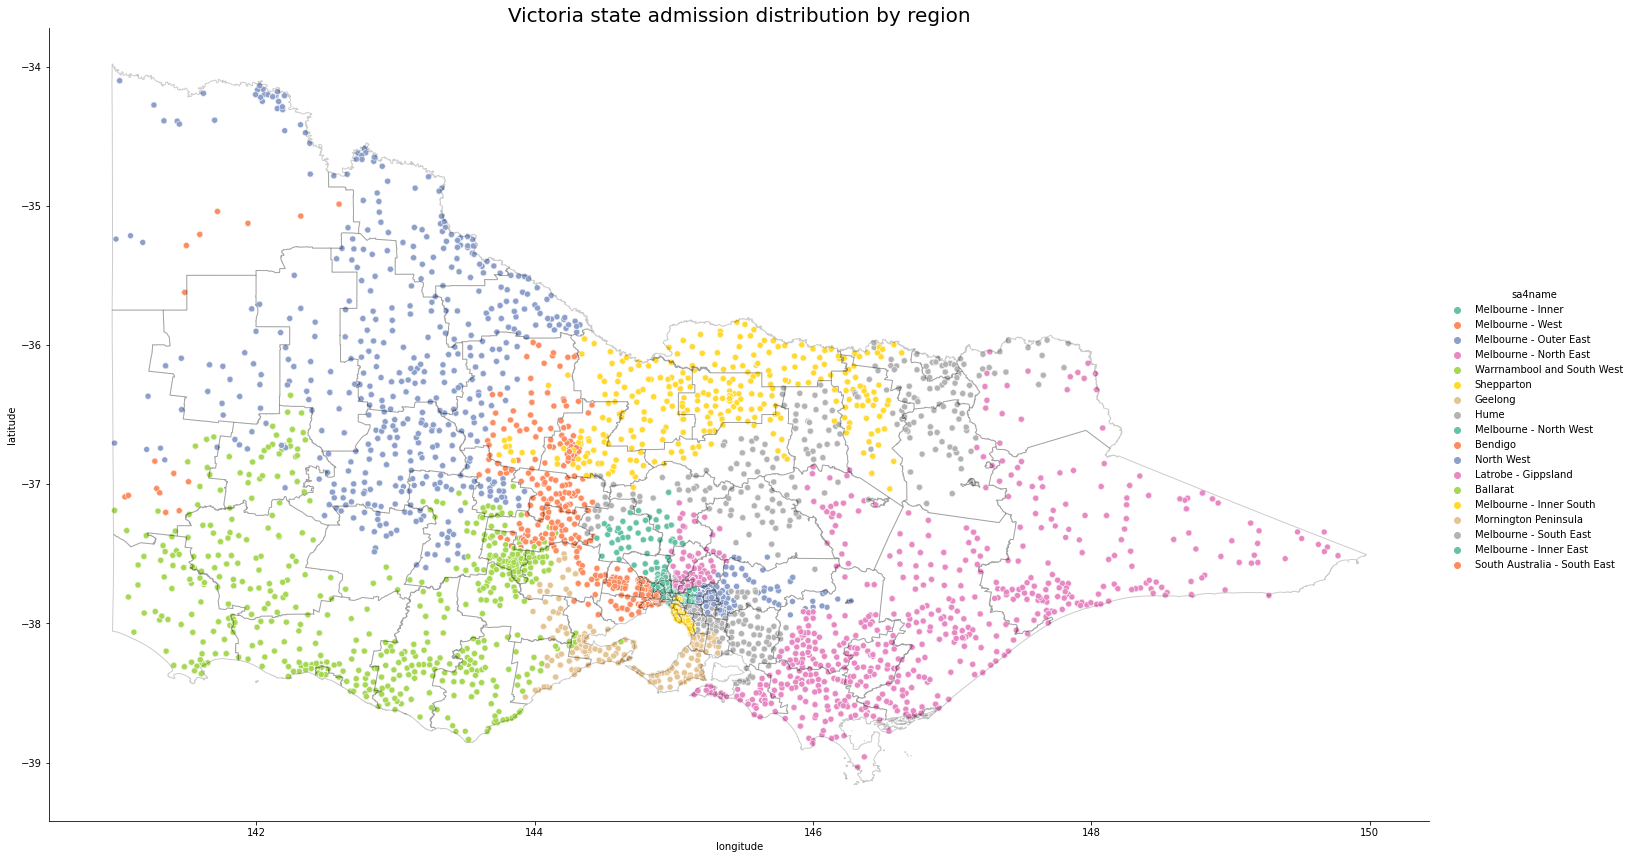

In [30]:
plt.figure()
palette = sns.color_palette('Set2', n_colors=len(VIC_df.sa4name.unique())-1)
rel = sns.relplot(x="longitude", y="latitude", hue="sa4name", data=VIC_df,height=20, palette=palette,);
VIC_state.plot(facecolor="none",edgecolor="black" , ax=rel.fig.axes[0], alpha=0.2)# parse dates for plot's title
plt.title('Victoria state admission distribution by region', fontdict = {'fontsize' : 20})
plt.show()

<div id="heading--2-8"/>

### 2.8. Admission Type (Feature Engineering)

- __Admission Type__ could be: 
    - EMERGENCY (1 most severe, 5 least severe)
    - ELECTIVE  
    
* __etriage__: ED triage category (1 most severe, 5 least severe)
* __elective__: Elective admission to hospital

* handle __missing data__ based on __elective__ info

In [31]:
fillna_list = ['etriage']
for col in fillna_list:
    if col in df.columns:
        df[col] = df[col][df.elective==0].fillna(0) # Not elective but missed
        df[col] = df[col].fillna(6) # elective

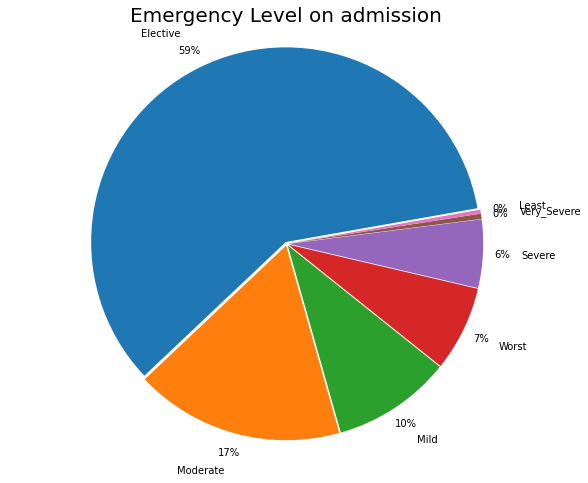

In [32]:
plt_cnf={'explode':[0.01,0.01], 'startangle':10,'labeldistance':1.2, 'labels':True, 'title':'Emergency Level on admission'}
E_dict = dict(zip([6,5,4,3,2,1,0], ['Elective','Least','Mild','Moderate','Severe','Very_Severe','Worst']))
df['etriage_cat'] = df['etriage'].replace(E_dict)
check_list = ['etriage_cat']
value_counts_percent(df,check_list, plot=True, plt_cnf=plt_cnf)

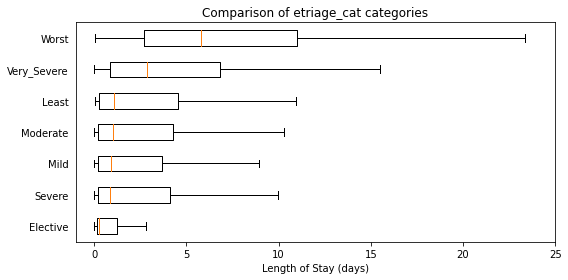

In [33]:
boxplot_los_groupby(df,'etriage_cat', los_range=(-1, 25))

<div id="heading--2-9"/>

### 2.9. Insurance

* __cpvthlth__: Does the patient have private health activated.
    - 0 : not Private 
    - 1: Private 

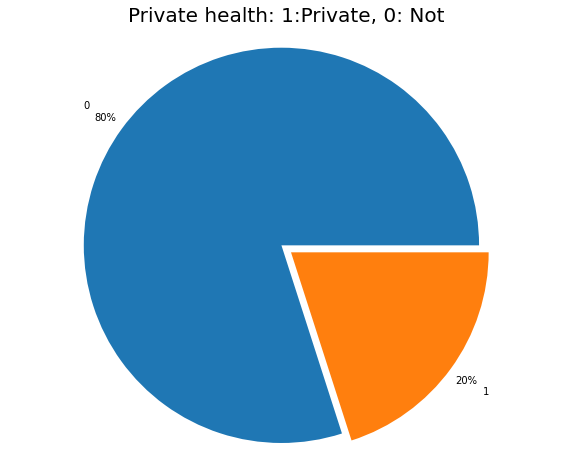

In [34]:
plt_cnf={'explode':[0.05,0.01], 'startangle':0,'labeldistance':1.2, 'labels':True, 'title':'Private health: 1:Private, 0: Not'}
value_counts_percent(df,['cpvthlth'],plot=True, plt_cnf=plt_cnf)

* '__private health activated__' patients have the lowest LOS. 

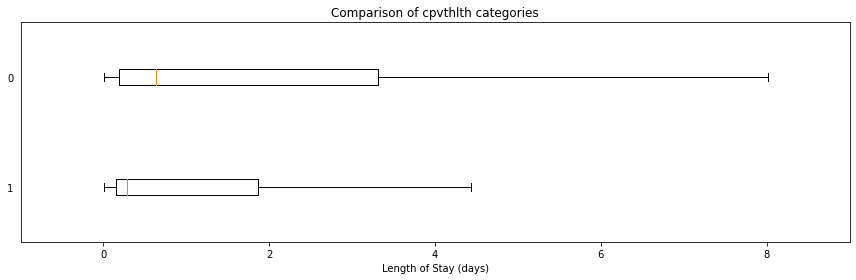

In [35]:
boxplot_los_groupby(df,'cpvthlth', los_range=(-1, 9),size=(12,4))


<div id="heading--2-10"/>

### 2.10 ICD-10-AM Code (Feature Engineering)

From [www.ihpa.gov.au/](https://www.ihpa.gov.au/what-we-do/icd-10-am-achi-acs-current-edition): CD-10-AM/ACHI/ACS Eleventh Edition, implemented 1 July 2019, is the current edition used for classifying episodes of admitted patient care across Australian hospital services. 
<center><img src="LOS/ICD-10-AM-Chapters.png"/></center>

In [36]:
df['icd10Chapter'] = df['icd10'].astype(str).str[0]
sub_chapte = df['icd10'].astype(str).str[1:3].astype('int')

In [37]:
# replace 'neoplasms'
df['icd10Chapter'] = np.where(df['icd10Chapter'] =='C'  , 'C/D', df['icd10Chapter'])
df['icd10Chapter'] = np.where((df['icd10'].astype(str).str[0]=='D') & (sub_chapte<49) , 'C/D', df['icd10Chapter'])
# replace 'Infectious'
df['icd10Chapter'] = np.where((df['icd10'].astype(str).str[0]=='A') | (df['icd10'].astype(str).str[0]=='B') , 'AB', df['icd10Chapter'])
# replace 'injury'
df['icd10Chapter'] = np.where((df['icd10'].astype(str).str[0]=='S') | (df['icd10'].astype(str).str[0]=='T') , 'S/T', df['icd10Chapter'])
# replace 'ex morbility'
df['icd10Chapter'] = np.where((df['icd10'].astype(str).str[0]=='V') | (df['icd10'].astype(str).str[0]=='Y') , 'V-Y', df['icd10Chapter'])

In [38]:
# Associated category names
diag_dict = {'AB': 'Infectious', 'C/D': 'Neoplasms', 'D': 'Blood',
             'E': 'Endocrine', 'F': 'Mental', 'G': 'Nervous', 'H': 'Eye/Ear',
             'I': 'Circulatory', 'J': 'Respiratory', 'K': 'Digestive', 'L': 'Skin', 
             'M': 'Muscular', 'N': 'Genitourinary', 'O': 'Pregnancy', 'P': 'Prenatal',
             'Q': 'Congenital', 'R': 'Symptoms', 'S/T': 'Injury',
             'U-V': 'Morbidity', 'Z': 'misc'}
df['ICD10AM'] = df['icd10Chapter'].replace(diag_dict)

In [39]:
df[['icd10','icd10Chapter','ICD10AM']].head()

,icd10,icd10Chapter,ICD10AM
0,D50.9,D,Blood
1,M50.0,M,Muscular
2,M50.0,M,Muscular
3,M50.0,M,Muscular
4,M50.0,M,Muscular


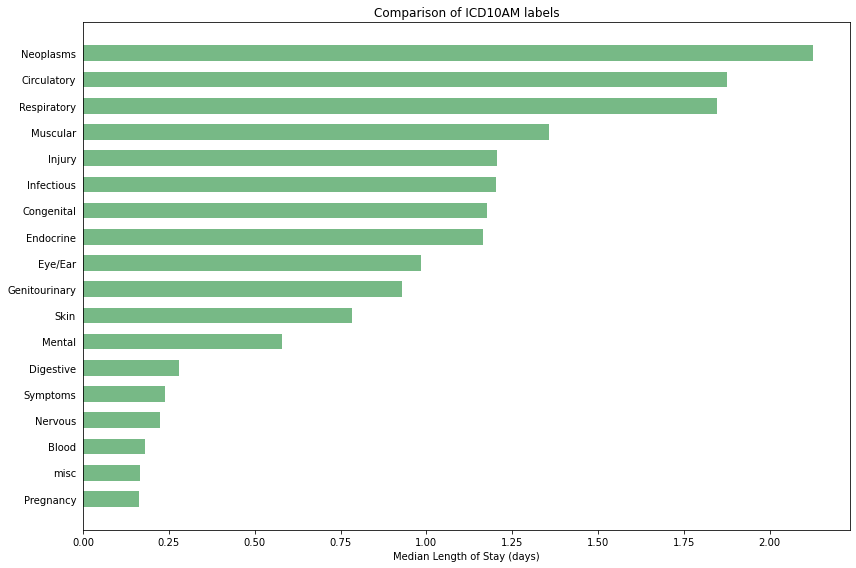

In [40]:
plot_los_groupby(df,'ICD10AM', size=(12,8))

<div id="heading--2-11"/>

### 2.11 Age (Feature Engineering)

In [41]:
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 120]
labels = ['<20','20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89','+90']

df['age_range'] = pd.cut(df.age, bins, labels = labels,include_lowest = True)

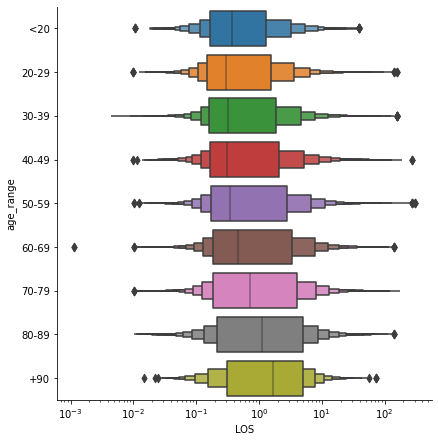

In [42]:
#boxplot_los_groupby(df,'age_range', los_range=(-1, 13), size=(12,8))
g = sns.catplot(x="LOS", y="age_range", data=df[['LOS','age_range']], kind="boxen", height=6,orient="h");
g.set(xscale="log")
# change the lables
age_dict = dict(zip(labels, [1,2,3,4,5,6,7,8,9]))
df['age_range'] = df['age_range'].replace(age_dict)

<div id="heading--3"/>

## 3. __Data Preprocessing__

In [43]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(df.head(1))

,Unnamed: 0,dt,visit,urno,age,sex,indig,cadttext,cward,cbed,cunit,csource,cadmitclass,cpvthlth,cadmitmbs,cexpstay,evisit,ecomplaintcode,ecomplaint,etriage,cicu,ctheatre,pvisit,padmdtext,punit,plos,pcomorbid,ageadmission,agerisk,combinedscore,survive10,c_mi,c_chf,c_pvd,c_cvd,c_dementia,c_cpd,c_ctd,c_pud,c_mld,c_dmnc,c_dmcc,c_hemi,c_renal,c_cancer,c_ld,c_metca,c_aids,pdiag,pdiagd,pproc,pprocd,pcall,picu,ph,bicarb,lactate,hb,wcc,creatinine,platelets,postcode,sadd,srsd,ser,seo,ip12m,ip24m,ed12m,ed24m,atrisk,id,frailty,rdt,cadt,padt,sequence,outcome,wies,drg,icd10,diagnosis,dobt,dodt,admitdt,adt,ad,dischargedt,ddt,dd,died,dob,dod,call,eventdate,met,cb,arrest,anycall,hiout,anyarrest,charlsum,charl2,edvisit,ipany,edany,period,sequencelos,phc,bicarbc,lactatec,hbc,wccc,creatininec,plateletsc,phc2,bicarbc2,lactatec2,hbc2,wccc2,creatininec2,plateletsc2,male,unitcode,statin,transin,nhin,pmet,charl3,vascular,stroke,respiratory,renal,nsurg,genmed,cts,gensurg,ort,ent,card,elective,elective2,outlier,frail3,frail2,LOS,state,sa4,sa4name,Lat_precise,Long_precise,etriage_cat,icd10Chapter,ICD10AM,age_range
0,0,2019-07-23 15:01:37,897520,1226958.0,72.84599,F,0,2019-07-23 14:53:09,MTC,,N/L,HME,EAD,0,,0,NaN,NaN,NaN,6.0,0,0,8342444.0,2018-05-22 00:00:00,GAS,0,1.0,71.0,3.0,4.0,0.534,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,R19.5,Other faecal abnormalities,32090-00,Fibreoptic colonoscopy to caecum,NaN,0,7.4,25,1.5,119,4.7,75,152,3071,7.0,7.0,3.0,9.0,0,1,0,0,NaN,8674490,0.0,2019-07-23 15:00:35.456,2019-07-23 14:54:02.240,2018-05-21 23:59:57.952,1,H,Same Day Wgt,Q61B,D50.9,"Iron deficiency anaemia, unspecified",19460917,NaN,2019-07-23 14:53:09,2019-07-23 14:54:02.240,2019-07-23 00:00:00.000,2019-07-23 16:21:27,2019-07-23 16:21:25.120,2019-07-23 00:00:00.000,0,1946-09-17,NaN,0,NaN,0,0,0,0,No,0,1,0,No,0,0,NaN,2,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0.0,0,0,0,N/L,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,Yes,Normal,Normal,0.061319,VIC,206.0,Melbourne - Inner,-37.760049,145.008004,Elective,D,Blood,7


<div id="heading--3-1"/>

### 3.1. __Drop columns__

In [44]:
   
columns_to_remove = ['sex','pdiag', 'pproc','pdiagd','pprocd','ecomplaint','frail3','cunit','nhin','statin','transin','elective2',  # redundante
                     'vascular','stroke','respiratory','renal','nsurg','genmed','cts','gensurg','ort','ent','card',                 # redundante in (unitcode)
                     'sa4name', 'etriage_cat','icd10Chapter','age',                                                                 # redundante
                     'diagnosis', 'cadmitmbs',                                                                                      # codded           -cadmitmbs +'icd10', 
                     'drg', 'wies', 'period', 'survive10', 'agerisk', 'cexpstay', 'outcome', 'died', 'call', 'met', 'cb', 'arrest', # outcome/leakage
                     'cicu', 'ctheatre', 'atrisk', 'anycall','anyarrest',                                                           # outcome/leakage  -hiout
                     'cbed','postcode',                                                                                             # location
                     'dt','cadttext','padmdtext','rdt','cadt','padt','admitdt','adt','dischargedt','ddt', 'sequencelos',            # date/time
                     'dobt', 'dodt', 'ad','dd' ,'dob', 'dod', 'eventdate','ageadmission',                                           # date/time
                     'id', 'Unnamed: 0','sequence','pvisit',                                                                        # id                -'visit','urno',  
                     'phc','bicarbc','lactatec','hbc','wccc','creatininec','plateletsc','phc2','bicarbc2','lactatec2','hbc2',       # useless
                     'wccc2','creatininec2','plateletsc2',                                                                          # useless
                     'evisit','punit','plos' ,'Lat_precise','Long_precise','pcall'                                                  # useless                   
                    ]
new_columns = [col for col in df.columns if col not in columns_to_remove]
data = df[new_columns]

with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(data.head(1))

,visit,urno,indig,cward,csource,cadmitclass,cpvthlth,ecomplaintcode,etriage,pcomorbid,combinedscore,c_mi,c_chf,c_pvd,c_cvd,c_dementia,c_cpd,c_ctd,c_pud,c_mld,c_dmnc,c_dmcc,c_hemi,c_renal,c_cancer,c_ld,c_metca,c_aids,picu,ph,bicarb,lactate,hb,wcc,creatinine,platelets,sadd,srsd,ser,seo,ip12m,ip24m,ed12m,ed24m,frailty,icd10,hiout,charlsum,charl2,edvisit,ipany,edany,male,unitcode,pmet,charl3,elective,outlier,frail2,LOS,state,sa4,ICD10AM,age_range
0,897520,1226958.0,0,MTC,HME,EAD,0,NaN,6.0,1.0,4.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,7.4,25,1.5,119,4.7,75,152,7.0,7.0,3.0,9.0,0,1,0,0,0.0,D50.9,No,1,0,No,0,0,0,N/L,0,1,1,Yes,Normal,0.061319,VIC,206.0,Blood,7


<div id="heading--3-2"/>

### 3.2. __Missing Values__

In [45]:
is_na=data.isna().sum().sort_values(ascending=False)
print('\nMissing value percentages sorted:')
display(pd.DataFrame(np.round(100*is_na/data.shape[0],2)[:12]))


Missing value percentages sorted:


,0
ecomplaintcode,66.35
pcomorbid,46.88
combinedscore,46.88
frailty,42.69
sa4,0.68
state,0.44
seo,0.44
ser,0.44
srsd,0.44
sadd,0.44


In [46]:
# pcomorbid:     an cat type column                     with values=[0,1,2,3,4,5]
# combinedscore: Combined Charlson score                with int values=[0-14]
# frailty:       Hospital frailty risk score            with values=[0.0, 1.5, 0.8, 1.4, 1.1, 1.6, 2.3, 0.7, 3.2 ,0.4]
# 'sadd','srsd', 'ser', 'seo': 'patient-demographics'   with int values : [0-10]
# 'hiout'  
fillna_list = ['frailty','pcomorbid','combinedscore','sadd','srsd','ser','seo','ecomplaintcode', 'sa4','state']
for col in fillna_list:
    if col in data.columns:
        data[col] = data[col].fillna(-1)

        
if 'hiout' in data.columns:
    data = data[data['hiout'].notna()]

print('\nDimensions of the dataset after handling columns with high MisVal :\n\n -->',data.shape,'\n\n')
print('Total Number of remained missing values --> {}'.format(data.isna().sum().sum()))


Dimensions of the dataset after handling columns with high MisVal :

 --> (669469, 64) 


Total Number of remained missing values --> 0


<div id="heading--3-3"/>

### 3.3. __Recategorization__

In [47]:
binary_cols = ['frail2', 'hiout', 'edvisit','outlier']
for col in binary_cols:
    if col in data.columns:
        if col != 'frail2':
            data[col] = data[col].map({'Yes': 1, 'No': 0})
        else:
            data[col] = data[col].map({'Frail': 1, 'Normal': 0})


In [48]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(data.head(2))

,visit,urno,indig,cward,csource,cadmitclass,cpvthlth,ecomplaintcode,etriage,pcomorbid,combinedscore,c_mi,c_chf,c_pvd,c_cvd,c_dementia,c_cpd,c_ctd,c_pud,c_mld,c_dmnc,c_dmcc,c_hemi,c_renal,c_cancer,c_ld,c_metca,c_aids,picu,ph,bicarb,lactate,hb,wcc,creatinine,platelets,sadd,srsd,ser,seo,ip12m,ip24m,ed12m,ed24m,frailty,icd10,hiout,charlsum,charl2,edvisit,ipany,edany,male,unitcode,pmet,charl3,elective,outlier,frail2,LOS,state,sa4,ICD10AM,age_range
0,897520,1226958.0,0,MTC,HME,EAD,0,-1,6.0,1.0,4.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,7.4,25,1.5,119,4.7,75,152,7.0,7.0,3.0,9.0,0,1,0,0,0.0,D50.9,0,1,0,0,0,0,0,N/L,0,1,1,1,0,0.061319,VIC,206.0,Blood,7
1,962323,438854.0,0,10W,HWL,EAD,0,-1,6.0,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.4,25,1.5,120,9.0,90,250,7.0,7.0,2.0,9.0,0,0,0,0,-1.0,M50.0,0,0,0,0,0,0,0,N/S,0,0,1,0,0,7.208461,VIC,206.0,Muscular,7


<div id="heading--4"/>

## 4. __Data Cleanup Function__

The `mimic_los_cleanup` performs all of the above data cleanup and feature engineering steps. 

In [55]:
def mimic_los_cleanup(adm_csv=data_path+'@admission_all.csv', 
                      postcode_csv='LOS/extra_info/australian_postcodes.csv', verbose=True):
    # Import CSV tables
    df =  pd.read_csv(adm_csv, low_memory=False)
    df_pc = pd.read_csv(postcode_csv)
    
    if verbose: 
        print('(1/5) Completed .csv imports')
        
    # Feature Engineering for Length of Stay (LOS) target variable
    # Convert admission and discharge times to datatime type
    # Convert timedelta type into float 'days', 86400 seconds in a day
    df['admitdt'] = pd.to_datetime(df['admitdt'])
    df['dischargedt'] = pd.to_datetime(df['dischargedt'])
    df['LOS'] = (df['dischargedt'] - df['admitdt']).dt.total_seconds()/86400
    
    # Mark admissions where patients died in boolean column
    # drop atients who died
    df['died'] = df['died'].map(dict(Yes=1, No=0))
    df = df[df.died != 1]
    
    # postcode (Feature Engineering)
    df['postcode'] = df['postcode'].fillna(0)
    df['postcode'] = df['postcode'].astype('int')
    
    # Merge postcode data with hospital data
    # delete postcode dataframe which not needed anymore
    df = df.merge(df_pc[['postcode','state', 'sa4','sa4name','Lat_precise','Long_precise']], on="postcode", how='left')
    del df_pc
    if verbose: 
        print('(2/5) Completed postcode (Feature Engineering).')
    
    # Admission Type (Feature Engineering)

    # handle missing data based on elective info
    fillna_list = ['etriage']
    for col in fillna_list:
        if col in df.columns:
            df[col] = df[col][df.elective==0].fillna(0) # Not elective but missed
            df[col] = df[col].fillna(6) # elective
    
    # ICD-10-AM Code (Feature Engineering)
    
    df['icd10Chapter'] = df['icd10'].astype(str).str[0]
    sub_chapte = df['icd10'].astype(str).str[1:3].astype('int')
    # replace 'neoplasms'
    df['icd10Chapter'] = np.where(df['icd10Chapter'] =='C'  , 'C/D', df['icd10Chapter'])
    df['icd10Chapter'] = np.where((df['icd10'].astype(str).str[0]=='D') & (sub_chapte<49) , 'C/D', df['icd10Chapter'])
    # replace 'Infectious'
    df['icd10Chapter'] = np.where((df['icd10'].astype(str).str[0]=='A') | (df['icd10'].astype(str).str[0]=='B') , 'AB', df['icd10Chapter'])
    # replace 'injury'
    df['icd10Chapter'] = np.where((df['icd10'].astype(str).str[0]=='S') | (df['icd10'].astype(str).str[0]=='T') , 'S/T', df['icd10Chapter'])
    # replace 'ex morbility'
    df['icd10Chapter'] = np.where((df['icd10'].astype(str).str[0]=='V') | (df['icd10'].astype(str).str[0]=='Y') , 'V-Y', df['icd10Chapter'])
    
    # Associated category names
    diag_dict = {'AB': 'Infectious', 'C/D': 'Neoplasms', 'D': 'Blood',
                 'E': 'Endocrine', 'F': 'Mental', 'G': 'Nervous', 'H': 'Eye/Ear',
                 'I': 'Circulatory', 'J': 'Respiratory', 'K': 'Digestive', 'L': 'Skin', 
                 'M': 'Muscular', 'N': 'Genitourinary', 'O': 'Pregnancy', 'P': 'Prenatal',
                 'Q': 'Congenital', 'R': 'Symptoms', 'S/T': 'Injury',
                 'U-V': 'Morbidity', 'Z': 'misc'}
    df['ICD10AM'] = df['icd10Chapter'].replace(diag_dict)
    
    if verbose: 
        print('(3/5) Completed Admission Type and ICD-10-AM Code (Feature Engineering)')
        
    # Age (Feature Engineering)
    bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 120]
    labels = [1,2,3,4,5,6,7,8,9] #['<20','20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89','+90']
    df['age_range'] = pd.cut(df.age, bins, labels = labels,include_lowest = True)
    
    # Drop useless columns
    columns_to_remove = ['sex','pdiag', 'pproc','pdiagd','pprocd','ecomplaint','frail3','cunit','nhin','statin','transin','elective2',  # redundante
                         'vascular','stroke','respiratory','renal','nsurg','genmed','cts','gensurg','ort','ent','card',                 # redundante in (unitcode)
                         'sa4name', 'etriage_cat','icd10Chapter','age',                                                                 # redundante
                         'diagnosis', 'cadmitmbs',                                                                                      # codded           -cadmitmbs +'icd10', 
                         'drg', 'wies', 'period', 'survive10', 'agerisk', 'cexpstay', 'outcome', 'died', 'call', 'met', 'cb', 'arrest', # outcome/leakage
                         'cicu', 'ctheatre', 'atrisk', 'anycall','anyarrest',                                                           # outcome/leakage  -hiout
                         'cbed','postcode',                                                                                             # location
                         'dt','cadttext','padmdtext','rdt','cadt','padt','admitdt','adt','dischargedt','ddt', 'sequencelos',            # date/time
                         'dobt', 'dodt', 'ad','dd' ,'dob', 'dod', 'eventdate','ageadmission',                                           # date/time
                         'id', 'Unnamed: 0','sequence','pvisit',                                                                        # id                -'visit','urno',  
                         'phc','bicarbc','lactatec','hbc','wccc','creatininec','plateletsc','phc2','bicarbc2','lactatec2','hbc2',       # useless
                         'wccc2','creatininec2','plateletsc2',                                                                          # useless
                         'evisit','punit','plos' ,'Lat_precise','Long_precise','pcall'                                                  # useless                   
                        ]
    new_columns = [col for col in df.columns if col not in columns_to_remove]
    data = df[new_columns]
    
    if verbose: 
        print('(4/5) Completed Age Feature Engineering and Droping useless columns')
    
    # Missing Values   
    fillna_list = ['frailty','pcomorbid','combinedscore','sadd','srsd','ser','seo','ecomplaintcode', 'sa4','state']
    for col in fillna_list:
        if col in data.columns:
            data[col] = data[col].fillna(-1)

    if 'hiout' in data.columns:
        data = data[data['hiout'].notna()]
        
    # Recategorization
    binary_cols = ['frail2', 'hiout', 'edvisit','outlier']
    for col in binary_cols:
        if col in data.columns:
            if col != 'frail2':
                data[col] = data[col].map({'Yes': 1, 'No': 0})
            else:
                data[col] = data[col].map({'Frail': 1, 'Normal': 0})
    
    
    if verbose: 
        print('(5/5) Completed missing value handeling')
    


    if verbose: 
        print('Data Preprocessing complete.')
    
    print('\nTotal Number of remained missing values --> {}'.format(data.isna().sum().sum()))
    print('\nDimensions of the final dataset:\n',df.shape)
    
    return data
    
    

In [56]:
df_final = mimic_los_cleanup()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_final.head(2))

(1/5) Completed .csv imports
(2/5) Completed postcode (Feature Engineering).
(3/5) Completed Admission Type and ICD-10-AM Code (Feature Engineering)
(4/5) Completed Age Feature Engineering and Droping useless columns
(5/5) Completed missing value handeling
Data Preprocessing complete.

Total Number of remained missing values --> 0

Dimensions of the final dataset:
 (669498, 154)


,visit,urno,indig,cward,csource,cadmitclass,cpvthlth,ecomplaintcode,etriage,pcomorbid,combinedscore,c_mi,c_chf,c_pvd,c_cvd,c_dementia,c_cpd,c_ctd,c_pud,c_mld,c_dmnc,c_dmcc,c_hemi,c_renal,c_cancer,c_ld,c_metca,c_aids,picu,ph,bicarb,lactate,hb,wcc,creatinine,platelets,sadd,srsd,ser,seo,ip12m,ip24m,ed12m,ed24m,frailty,icd10,hiout,charlsum,charl2,edvisit,ipany,edany,male,unitcode,pmet,charl3,elective,outlier,frail2,LOS,state,sa4,ICD10AM,age_range
0,897520,1226958.0,0,MTC,HME,EAD,0,-1,6.0,1.0,4.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,7.4,25,1.5,119,4.7,75,152,7.0,7.0,3.0,9.0,0,1,0,0,0.0,D50.9,0,1,0,0,0,0,0,N/L,0,1,1,1,0,0.061319,VIC,206.0,Blood,7
1,962323,438854.0,0,10W,HWL,EAD,0,-1,6.0,-1.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.4,25,1.5,120,9.0,90,250,7.0,7.0,2.0,9.0,0,0,0,0,-1.0,M50.0,0,0,0,0,0,0,0,N/S,0,0,1,0,0,7.208461,VIC,206.0,Muscular,7


<div id="heading--5"/>

## 5. __Save the cleaned data__

In [49]:
data.to_csv(data_path+'@admission_clean_LOS.csv', index=False)